# Installing Dependancies

In [1]:
from google.colab import drive
import sys

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab/RRA_RL/"
sys.path.append("/content/gdrive/My Drive/Colab/RRA_RL/")

Mounted at /content/gdrive


In [2]:
pip install pyfolio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.4 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88650 sha256=b53e79af26a3234d9d654c77d22765d3eadb342d646a0e019b5c04a5e09e989e
  Stored in directory: /root/.cache/pip/wheels/71/38/bc/e53700cfd8b0ad6b539d2fbaaf060ed8a299e7622a5b86ef42
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39754 sha256=2da48f329175aa4726929cd03ba06748f70f1a310db0bd73416353de958dce7f
  Stored in directory: /root/.cache/pip/wheels/0e/2e/f2/d6d2d9a1eb8fbbd9949bb5d4c00f753e3b74e5bd7ed10b1d36
Successfully built pyfolio empyrical


In [3]:
pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.9 MB/s eta 0:00:00


In [4]:
pip install Riskfolio-Lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 23.0 MB/s eta 0:00:00


# Preprocessing

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime

In [6]:
import numpy as np
import math
import time

import gym
from gym.utils import seeding
from gym import spaces

import yfinance as yf

# Defining Hyperparameters

### Select the tickers and timeframe

In [7]:
tickers = ["AAPL", "GE", "JPM", "MSFT", "VOD", "NKE", "NVDA", "MMM"]

# Download historical data for the tickers

data_train = yf.download(tickers, start='2006-01-03', end='2008-01-03')['Adj Close']
data_test = yf.download(tickers, start='2008-01-04', end='2009-01-05')['Adj Close']  # validate on 1 year

data_plot = pd.concat([data_train, data_test])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  8 of 8 completed


In [8]:
returns = data_train.pct_change()
market_data = yf.download('^GSPC', start='2007-01-03', end='2008-01-03')['Adj Close'].pct_change().dropna()  # compare with SP500

betas = {}  # calculate beta value and store it in dictionary
for t in tickers:
    cov = returns[t].cov(market_data)
    market_var = market_data.var()
    beta = cov/market_var
    betas[t] = beta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[*********************100%%**********************]  1 of 1 completed


### Check if all tickers have the same number of data points

In [9]:
# sort the original pd data with beta (column ordered in ascending beta)
sorted_cols = sorted(data_train.columns, key=lambda x: betas.get(x, 0))
sorted_data_test = data_test[sorted_cols]
sorted_data_test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MMM,NKE,GE,MSFT,VOD,AAPL,JPM,NVDA
Date,,,,,,,,
2008-01-04,50.194317,12.602220,143.309479,25.017332,13.747048,5.450885,27.268024,6.880692
2008-01-07,49.795273,12.677745,143.866241,25.184690,13.969871,5.377923,27.541161,6.169689
2008-01-08,49.242737,12.620591,140.764648,24.340588,13.973649,5.184469,26.448574,6.300422
2008-01-09,49.230453,12.649167,142.355194,25.060986,13.992532,5.431204,26.821650,6.626107
2008-01-10,49.242737,12.765515,142.832352,24.980942,14.071844,5.389427,27.534498,6.488494
...,...,...,...,...,...,...,...,...
2008-12-26,35.186909,10.317824,66.926315,14.177217,7.544974,2.597836,20.395231,1.722467
2008-12-29,34.953339,10.147796,65.627197,14.051223,7.521111,2.622055,20.381536,1.777513
2008-12-30,36.089622,10.303309,66.297714,14.332842,7.859181,2.612368,21.223356,1.839439


In [10]:
data_test.head(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,AAPL,GE,JPM,MMM,MSFT,NKE,NVDA,VOD
Date,,,,,,,,
2008-01-04,5.450885,143.309479,27.268024,50.194317,25.017332,12.60222,6.880692,13.747048


### Visualization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


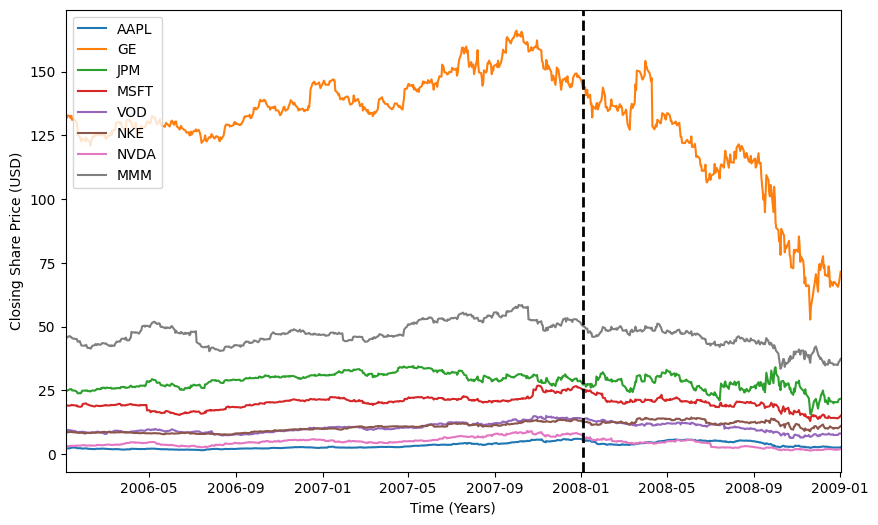

In [11]:
plt.rcParams["figure.figsize"] = (10,6)
for i in tickers:
    plt.plot(data_plot[i], label=i)

# only one line may be specified; full height
plt.axvline(pd.to_datetime('2008-01-04'), color='black', linestyle='--', lw=2)
plt.legend(loc='upper left')
plt.margins(x=0)
plt.ylabel("Closing Share Price (USD)")
plt.xlabel("Time (Years)")
plt.savefig('data0.png',bbox_inches='tight')

# Validating Results

In [12]:
import numpy as np
import random

In [13]:
rebalance_period = 1 #checking for balance (composition) everyday
test_re_df = sorted_data_test#.iloc[::rebalance_period, :]

In [14]:
length = test_re_df.shape[0] #number of data points in testing dataset
stocks = test_re_df.shape[1] #number of stocks/assets in dataset

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
import riskfolio as rp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
portfolio_weights_equal = np.ones([test_re_df.shape[0],test_re_df.shape[1]])/test_re_df.shape[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
return_stocks = test_re_df.pct_change()
return_stocks_equal = np.sum(return_stocks.multiply(portfolio_weights_equal),axis=1)
Cumulative_returns_daily_equal = (1+return_stocks_equal).cumprod()

### Load $RRA-RL$ Policy Weights
### Calculate Cumulative Returns

In [19]:
def calculate_cumulative_return(allocation):
  cr = np.zeros((allocation.shape[0], allocation.shape[1]-1))
  for i in range(allocation.shape[0]):
    return_stocks_equal = np.sum(return_stocks.multiply(allocation[i][:-1]),axis=1)
    cumulative_returns = (1+return_stocks_equal).cumprod()
    cr[i,:] = cumulative_returns

  return cr

In [20]:
def calculate_simulation_mean(allocation):
  allo = np.empty((allocation.shape[0], allocation.shape[1], allocation.shape[-1]))
  for i in range(allo.shape[0]):
    allo[i, :] = np.mean(allocation[i], axis=1)
  return allo

In [21]:
# calculating the cumulative return for robustRL

# trained on EOU
allocation_data = np.load('/content/gdrive/MyDrive/Colab/RRA_RL/ex4/save100/wt_history.npy')
allocation100 = calculate_simulation_mean(allocation_data)

cumulative_returns_RobustRL_100 = calculate_cumulative_return(allocation100)

In [22]:
allocation100[-1][-2]
#cumulative_returns_RobustRL_100

array([0.11250281, 0.13881913, 0.17591676, 0.15032265, 0.13703169,
       0.11926012, 0.09156913, 0.07457748])

## Plotting all cumulative returns together



#### This is the best case run

### Loading Cumulative Returns for 5 RL Methods

### Bear Market

In [23]:
bear_validation_dir = '/content/gdrive/MyDrive/Colab/RRA_RL/Validation_Data/Bear/CR/'

Cumulative_returns_daily_drl_a2c = np.load(bear_validation_dir + 'CR_five_a2c.npy')
Cumulative_returns_daily_drl_ppo = np.load(bear_validation_dir + 'CR_five_ppo.npy')
Cumulative_returns_daily_drl_ddpg = np.load(bear_validation_dir + 'CR_five_ddpg.npy')
Cumulative_returns_daily_drl_sac = np.load(bear_validation_dir + 'CR_five_sac.npy')
Cumulative_returns_daily_drl_td3 = np.load(bear_validation_dir + 'CR_five_td3.npy')
Cumulative_returns_daily_drl_minvol = np.load(bear_validation_dir + 'CR_five_minvol.npy')

#### Best case

In [24]:
realData_bear = np.load('/content/gdrive/MyDrive/Colab/RRA_RL/ex5(bear)/save100/wt_history.npy')
realData_bear100 = calculate_simulation_mean(realData_bear)

cr_realData_bear100 = calculate_cumulative_return(realData_bear100)

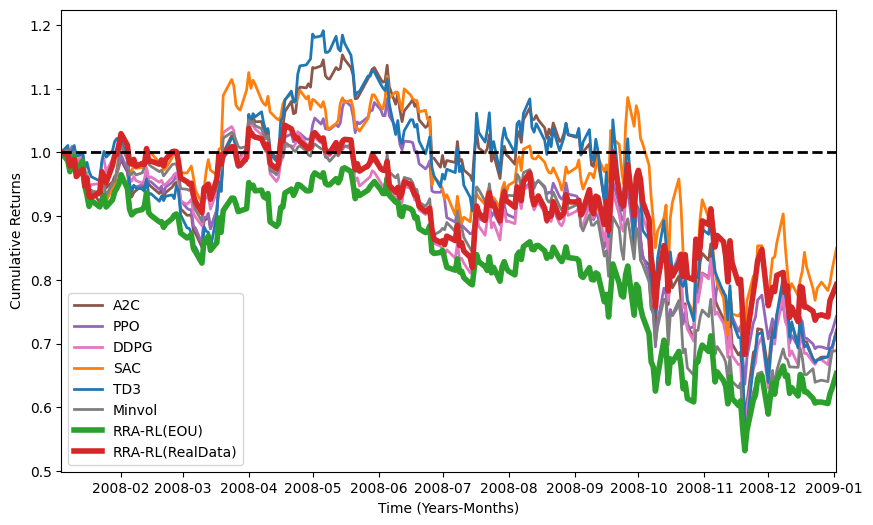

In [41]:
x = Cumulative_returns_daily_equal.index.values

a2c = Cumulative_returns_daily_drl_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
plt.plot(x, a2c, color='tab:brown', label='A2C', linewidth =2.0)
ppo = Cumulative_returns_daily_drl_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
plt.plot(x, ppo, color='tab:purple', label='PPO', linewidth =2.0)
ddpg = Cumulative_returns_daily_drl_ddpg[np.argmax(Cumulative_returns_daily_drl_ddpg[:,-1])]
plt.plot(x, ddpg, color='tab:pink', label='DDPG', linewidth =2.0)
sac = Cumulative_returns_daily_drl_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
plt.plot(x, sac, color='tab:orange', label='SAC', linewidth =2.0)
td3 = Cumulative_returns_daily_drl_td3[np.argmax(Cumulative_returns_daily_drl_td3[:,-1])]
plt.plot(x, td3, color='tab:blue', label='TD3', linewidth =2.0)
minvol = Cumulative_returns_daily_drl_minvol
plt.plot(x, minvol, color='tab:gray', label='Minvol', linewidth =2.0)

"""
below is the cumumlative return for RobustRL
"""
# robustRLX075 = cumulative_returns_RobustRL_X075
# plt.plot(x, robustRLX075, color='tab:red', label='RRA-RL(RealData)', linewidth =4.0)

robustRL100 = cumulative_returns_RobustRL_100[np.argmax(cumulative_returns_RobustRL_100[:,-1])]
plt.plot(x, robustRL100, color='tab:green', label='RRA-RL(EOU)', linewidth =4.0)

robustRL_bear100 = cr_realData_bear100[np.argmax(cr_realData_bear100[:,-1])]
plt.plot(x, robustRL_bear100, color='tab:red', label='RRA-RL(RealData)', linewidth =4.0)

#plt.title("Performance Comparison under Bear Market (Best case, with P=1)")
plt.axhline(1, color='black', linestyle='--', linewidth =2.0)
plt.margins(x=0)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")
plt.legend()
plt.savefig(str(rebalance_period)+'_cumulative_returns_max0.png',bbox_inches='tight')

#### worst case

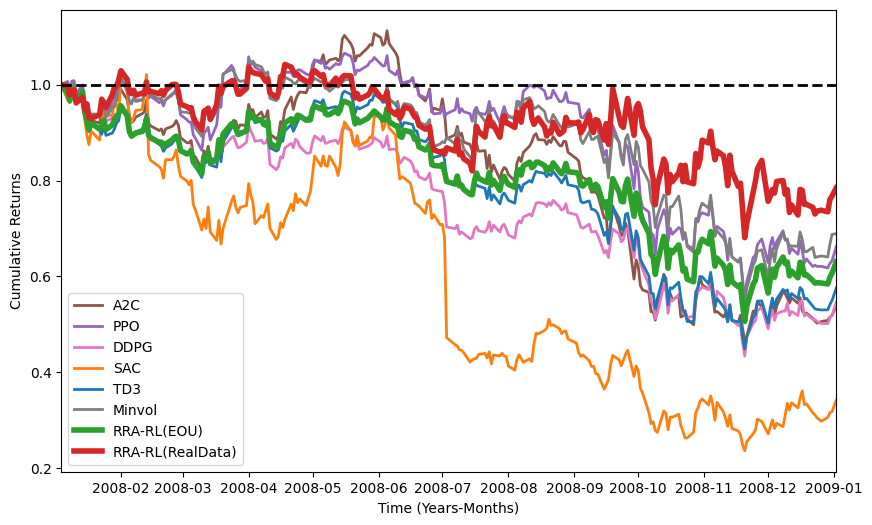

In [42]:
x = Cumulative_returns_daily_equal.index.values

a2c = Cumulative_returns_daily_drl_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
plt.plot(x, a2c, color='tab:brown', label='A2C', linewidth =2.0)
ppo = Cumulative_returns_daily_drl_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
plt.plot(x, ppo, color='tab:purple', label='PPO', linewidth =2.0)
ddpg = Cumulative_returns_daily_drl_ddpg[np.argmin(Cumulative_returns_daily_drl_ddpg[:,-1])]
plt.plot(x, ddpg, color='tab:pink', label='DDPG', linewidth =2.0)
sac = Cumulative_returns_daily_drl_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
plt.plot(x, sac, color='tab:orange', label='SAC', linewidth =2.0)
td3 = Cumulative_returns_daily_drl_td3[np.argmin(Cumulative_returns_daily_drl_td3[:,-1])]
plt.plot(x, td3, color='tab:blue', label='TD3', linewidth =2.0)
minvol = Cumulative_returns_daily_drl_minvol
plt.plot(x, minvol, color='tab:gray', label='Minvol', linewidth =2.0)

robustRL100 = cumulative_returns_RobustRL_100[np.argmin(cumulative_returns_RobustRL_100[:,-1])]
plt.plot(x, robustRL100, color='tab:green', label='RRA-RL(EOU)', linewidth =4.0)

robustRL_bear100 = cr_realData_bear100[np.argmin(cr_realData_bear100[:,-1])]
plt.plot(x, robustRL_bear100, color='tab:red', label='RRA-RL(RealData)', linewidth =4.0)

#plt.title("Performance Comparison under Bear Market (Worst case, with P=1)")
plt.axhline(1, color='black', linestyle='--', linewidth =2.0)
plt.margins(x=0)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")
plt.legend()
plt.savefig(str(rebalance_period)+'_cumulative_returns_min0.png',bbox_inches='tight')

#### average case

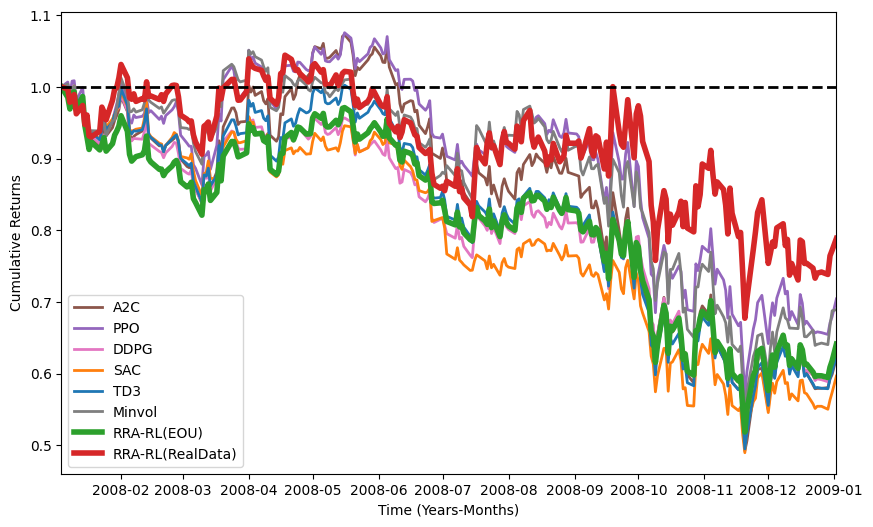

In [43]:
x = Cumulative_returns_daily_equal.index.values

a2c = np.mean(Cumulative_returns_daily_drl_a2c, axis=0)
plt.plot(x, a2c, color='tab:brown', label='A2C', linewidth =2.0)
ppo = np.mean(Cumulative_returns_daily_drl_ppo, axis=0)
plt.plot(x, ppo, color='tab:purple', label='PPO', linewidth =2.0)
ddpg = np.mean(Cumulative_returns_daily_drl_ddpg, axis=0)
plt.plot(x, ddpg, color='tab:pink', label='DDPG', linewidth =2.0)
sac = np.mean(Cumulative_returns_daily_drl_sac, axis=0)
plt.plot(x, sac, color='tab:orange', label='SAC', linewidth =2.0)
td3 = np.mean(Cumulative_returns_daily_drl_td3, axis=0)
plt.plot(x, td3, color='tab:blue', label='TD3', linewidth =2.0)
minvol = Cumulative_returns_daily_drl_minvol
plt.plot(x, minvol, color='tab:gray', label='Minvol', linewidth =2.0)

robustRL100 = np.mean(cumulative_returns_RobustRL_100, axis=0)
plt.plot(x, robustRL100, color='tab:green', label='RRA-RL(EOU)', linewidth =4.0)

robustRL_bear100 = np.mean(cr_realData_bear100, axis=0)
plt.plot(x, robustRL_bear100, color='tab:red', label='RRA-RL(RealData)', linewidth =4.0)

#plt.title("Performance Comparison under Bear Market (Average case, with P=1)")
plt.axhline(1, color='black', linestyle='--', linewidth =2.0)
plt.margins(x=0)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")
plt.legend()
plt.savefig(str(rebalance_period)+'_cumulative_returns_avg0.png',bbox_inches='tight')

### Load 5 Models' Allocation Policies

In [44]:
bear_validation_dir = '/content/gdrive/MyDrive/Colab/RRA_RL/Validation_Data/Bear/Weights/'

portfolio_weights_a2c = np.load(bear_validation_dir + 'Wt_five_a2c.npy')
portfolio_weights_ppo = np.load(bear_validation_dir + 'Wt_five_ppo.npy')
portfolio_weights_ddpg = np.load(bear_validation_dir + 'Wt_five_ddpg.npy')
portfolio_weights_sac = np.load(bear_validation_dir + 'Wt_five_sac.npy')
portfolio_weights_td3 = np.load(bear_validation_dir + 'Wt_five_td3.npy')
portfolio_weights_minvol = np.load(bear_validation_dir + 'Wt_five_minvol.npy')

In [45]:
portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_),axis=1)

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_),axis=1)

portfolio_weights_ddpg_ = portfolio_weights_ddpg[np.argmax(Cumulative_returns_daily_drl_ddpg[:,-1])]
return_stocks_ddpg = np.sum(return_stocks.multiply(portfolio_weights_ddpg_),axis=1)

portfolio_weights_sac_ = portfolio_weights_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_),axis=1)

portfolio_weights_td3_ = portfolio_weights_td3[np.argmax(Cumulative_returns_daily_drl_td3[:,-1])]
return_stocks_td3 = np.sum(return_stocks.multiply(portfolio_weights_td3_),axis=1)

# RRA-RL
portfolio_weights_RRA = realData_bear100[np.argmax(cr_realData_bear100[:,-1])]
return_stocks_RRA = np.sum(return_stocks.multiply(portfolio_weights_RRA[:-1]), axis=1)

portfolio_weights_EOU = allocation100[np.argmax(cumulative_returns_RobustRL_100[:,-1])]
return_stocks_EOU = np.sum(return_stocks.multiply(portfolio_weights_EOU[:-1]), axis=1)


In [ ]:
portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_),axis=1)

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_),axis=1)

portfolio_weights_ddpg_ = portfolio_weights_ddpg[np.argmin(Cumulative_returns_daily_drl_ddpg[:,-1])]
return_stocks_ddpg = np.sum(return_stocks.multiply(portfolio_weights_ddpg_),axis=1)

portfolio_weights_sac_ = portfolio_weights_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_),axis=1)

portfolio_weights_td3_ = portfolio_weights_td3[np.argmin(Cumulative_returns_daily_drl_td3[:,-1])]
return_stocks_td3 = np.sum(return_stocks.multiply(portfolio_weights_td3_),axis=1)

## Metrics

In [30]:
import pyfolio

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [31]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_ppo, set_context=False)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2008-01-04
End date,2009-01-02
Total months,12
,Backtest
Annual return,-31.3%
Cumulative returns,-31.3%
Annual volatility,45.3%
Sharpe ratio,-0.60
Calmar ratio,-0.69
Stability,0.70
Max drawdown,-45.7%


IndexError: ignored

In [46]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_a2c, set_context=False)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2008-01-04
End date,2009-01-02
Total months,12
,Backtest
Annual return,-31.8%
Cumulative returns,-31.8%
Annual volatility,39.4%
Sharpe ratio,-0.77
Calmar ratio,-0.73
Stability,0.67
Max drawdown,-43.6%


IndexError: ignored

In [33]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_ddpg, set_context=False)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2008-01-04
End date,2009-01-02
Total months,12
,Backtest
Annual return,-36.9%
Cumulative returns,-36.9%
Annual volatility,43.9%
Sharpe ratio,-0.83
Calmar ratio,-0.75
Stability,0.65
Max drawdown,-49.0%


IndexError: ignored

In [34]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_sac, set_context=False)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2008-01-04
End date,2009-01-02
Total months,12
,Backtest
Annual return,-43.6%
Cumulative returns,-43.6%
Annual volatility,55.6%
Sharpe ratio,-0.75
Calmar ratio,-0.76
Stability,0.32
Max drawdown,-57.3%


AttributeError: ignored

In [35]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_td3, set_context=False)

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2008-01-04
End date,2009-01-02
Total months,12
,Backtest
Annual return,-42.0%
Cumulative returns,-42.0%
Annual volatility,43.3%
Sharpe ratio,-1.04
Calmar ratio,-0.81
Stability,0.85
Max drawdown,-51.7%


IndexError: ignored

In [38]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_RRA, set_context=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2008-01-04
End date,2009-01-02
Total months,12
,Backtest
Annual return,-20.8%
Cumulative returns,-20.8%
Annual volatility,45.5%
Sharpe ratio,-0.29
Calmar ratio,-0.60
Stability,0.65
Max drawdown,-34.5%


IndexError: ignored

In [40]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_EOU, set_context=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2008-01-04
End date,2009-01-02
Total months,12
,Backtest
Annual return,-34.7%
Cumulative returns,-34.7%
Annual volatility,43.6%
Sharpe ratio,-0.76
Calmar ratio,-0.74
Stability,0.76
Max drawdown,-46.8%


IndexError: ignored